In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tables
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import scipy.signal as ss
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from simulate_triple import simulate
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from tools_plot import despine, set_style, regplot, scatterplot
import pandas as pd
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import pathlib
from causal_optoconnectics.core import find_response_spikes
from causal_optoconnectics.buzsaki import transfer_probability

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [4]:
colors = ['#1b9e77', '#d95f02', '#7570b3']

In [5]:
# base_path = pathlib.Path('/home/mikkel/data/data_branched_stim_idstsswitched')
# base_path = pathlib.Path('/home/mikkel/data/data_intermed/')
# base_path = pathlib.Path('/home/mikkel/data/dat_271119/')
base_path = pathlib.Path('/home/mikkel/data/dat_041219/')

In [6]:
connections = np.load(base_path / 'm.npz', allow_pickle=True)['m'][()]

In [7]:
N = connections.shape[0]

In [8]:
df = pd.DataFrame([
    (j, i, connections[i, j]) for i in range(N) for j in range(N) if i!=j],
    columns=['source', 'target', 'weight']
)

In [9]:
paths = [path for path in base_path.iterdir() if path.is_dir()]
paths = sorted(paths, key=lambda x: int(x.stem))[:15]

In [10]:
stim_delay = 2 # ms

In [11]:
def make_trials(stim_times, ts_base, ids_base, ts_branch, ids_branch):
    z1_branch = .5
    z1 = -2
    z2 = 0

    x1 = 0
    x2 = 2

    y1 = 2
    y2 = 4
    Z = np.ones((len(stim_times), N))
    X = np.zeros((len(stim_times), N))
    Y = np.zeros((len(stim_times), N))
    for i, t in enumerate(stim_times):
        # spikes 
        idx = np.searchsorted(ts_base, [t - stim_delay - z1_branch, t - stim_delay], side='right')
        id_spiked_before_branch = ids_base[idx[0]: idx[1]]

        idx = np.searchsorted(ts_branch[i], [z1, z2], side='right')
        id_spiked_before_stim = ids_branch[i][idx[0]: idx[1]]
        id_spiked_before = np.unique(np.concatenate((id_spiked_before_branch, id_spiked_before_stim)))

        Z[i, id_spiked_before] = 0

        idx = np.searchsorted(ts_branch[i], [x1, x2], side='right')
        id_spiked = np.unique(ids_branch[i][idx[0]: idx[1]])
        X[i, id_spiked] = 1

        idx = np.searchsorted(ts_branch[i], [y1, y2], side='right')
        id_spiked = np.unique(ids_branch[i][idx[0]: idx[1]])
        Y[i, id_spiked] = 1
    return Z, X, Y

In [12]:
X, Y, Z = [], [], []
for i, path in enumerate(tqdm(paths)):
    print('Loading', path)
    try:
        spks = np.load(path / 'spks1.npz', allow_pickle=True)['data'][()]
    except:
        print('Failed to load', path)
        start_after.append(start_after[i])
        continue

    ts_base = np.array(spks['spk_ts'])
    ids_base = np.array(spks['spk_ids'])
    
    stim_times = []
    ts_branch = []
    ids_branch = []
    for fname in path.glob('stimulation_data*.npz'):
        data = np.load(fname, allow_pickle=True)['data'][()]
        stim_time = data['t'] + stim_delay
        stim_times.append(stim_time)
        ts_branch.append(data['spk_ts'] - stim_time)
        ids_branch.append(data['spk_ids'])
        
    sort_idxs = np.argsort(stim_times)
    stim_times = np.array([stim_times[ii] for ii in sort_idxs])
    ts_branch = np.array([ts_branch[ii] for ii in sort_idxs])
    ids_branch = np.array([ids_branch[ii] for ii in sort_idxs])
    
    z, x, y = make_trials(stim_times, ts_base, ids_base, ts_branch, ids_branch)
    X.append(x)
    Y.append(y)
    Z.append(z)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

Loading /home/mikkel/data/dat_041219/0
Loading /home/mikkel/data/dat_041219/1
Loading /home/mikkel/data/dat_041219/2
Loading /home/mikkel/data/dat_041219/3
Loading /home/mikkel/data/dat_041219/4
Loading /home/mikkel/data/dat_041219/5
Loading /home/mikkel/data/dat_041219/6
Loading /home/mikkel/data/dat_041219/7
Loading /home/mikkel/data/dat_041219/8
Loading /home/mikkel/data/dat_041219/9
Loading /home/mikkel/data/dat_041219/10
Loading /home/mikkel/data/dat_041219/11
Loading /home/mikkel/data/dat_041219/12
Loading /home/mikkel/data/dat_041219/13
Loading /home/mikkel/data/dat_041219/14



In [13]:
# query = 'source > 300 and source < 800 and weight > 0 and target > 1000 and target < 3200'
# query = 'source < 1000 and weight > 0 and target >= 1000 and target < 3200'
query = 'source < 1000 and target >= 1000 and target < 3200'
sample = df.query(query)

In [14]:
sample['wr'] = sample.weight.round(3)
sample = sample.drop_duplicates('wr')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
# sample = sample.sample(2000)

In [16]:
X = np.concatenate(X)
Y = np.concatenate(Y)
Z = np.concatenate(Z)

In [35]:
Z.shape

(581103, 4000)

# look at all

In [18]:
def process(row):
    z = Z[:,int(row.source)]
    x = X[:,int(row.source)]
    y = Y[:,int(row.target)]
    y_ref = y[z==0]
    y_respons = y[x==1].mean()
    beta_iv = y_respons - y_ref.mean()
#     wald = (y[z==1].mean() - y[z==0].mean()) / (x[z==1].mean() - x[z==0].mean())
#     beta = y_respons - y[x==0].mean()
    beta = y_respons - np.random.choice(y[x==0], len(y_ref)).mean()
#     print(
#         len(y[z==1]), y[z==1].mean(), 
#         len(np.random.choice(y[x==0], int(sum(z)))), np.random.choice(y[x==0], int(sum(z))).mean())
#     return pd.Series({'beta_iv': beta_iv, 'beta': beta, 'hit_rate': x.mean(), 'wald': wald})
    return pd.Series({'beta_iv': beta_iv, 'beta': beta, 'hit_rate': x.mean()})

In [20]:
%time process(sample.iloc[0,:])

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 54.1 ms


beta       -0.078706
beta_iv     0.042939
hit_rate    0.027071
dtype: float64

In [21]:
from multiprocessing import  Pool

def parall_apply(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def apply(x): 
    return x.apply(process, axis=1, result_type="expand")

In [24]:
result = sample.join(sample.progress_apply(process, axis=1, result_type="expand"))

HBox(children=(IntProgress(value=0, max=2390), HTML(value='')))

In [25]:
# result = sample.join(parall_apply(sample, apply))

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\hat{\\beta}_{IV}$')

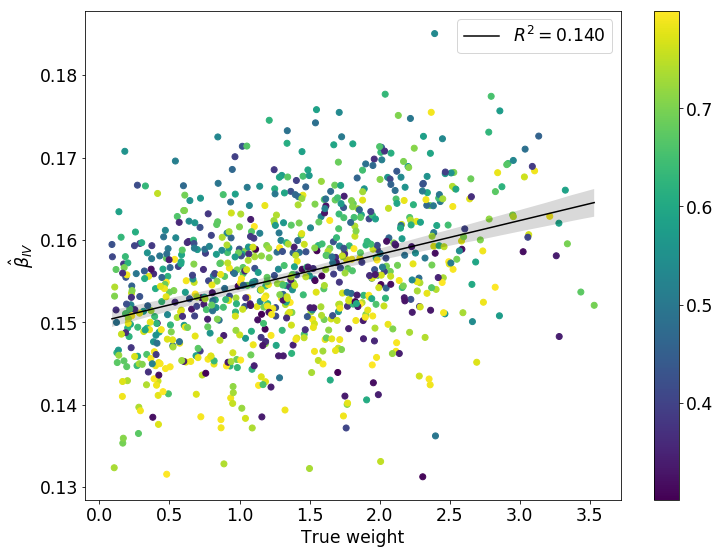

In [33]:
df_ = result.query('hit_rate > .3 and hit_rate < .8')
model = regplot(
    'weight', 'beta_iv', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\hat{\\beta}$')

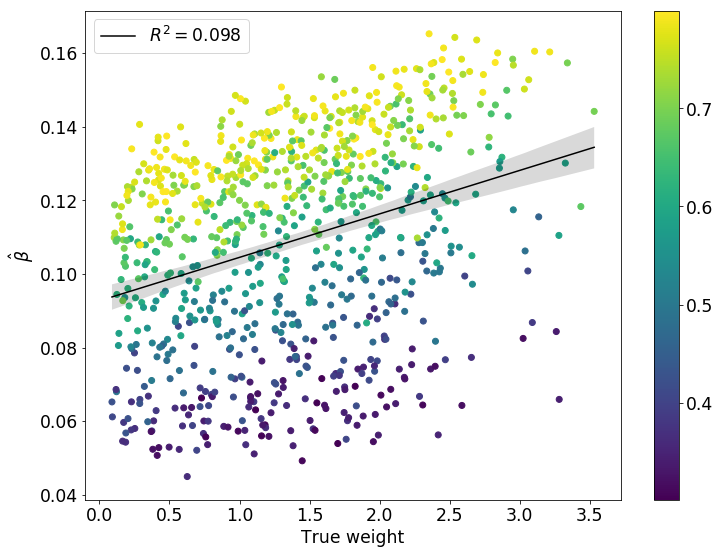

In [34]:
df_ = result.query('hit_rate > .3 and hit_rate < .8')
model = regplot(
    'weight', 'beta', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}$')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\hat{\\beta}$')

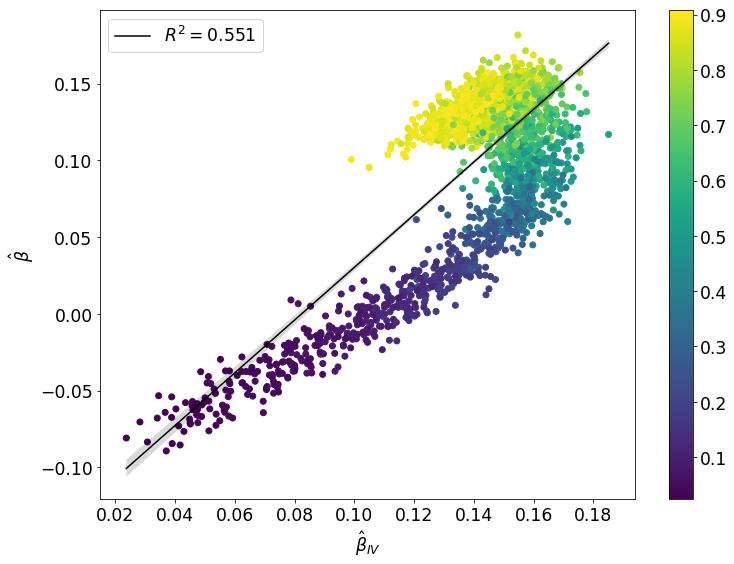

In [28]:
model = regplot(
    'beta_iv', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel(r'$\hat{\beta}_{IV}$')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'True weight')

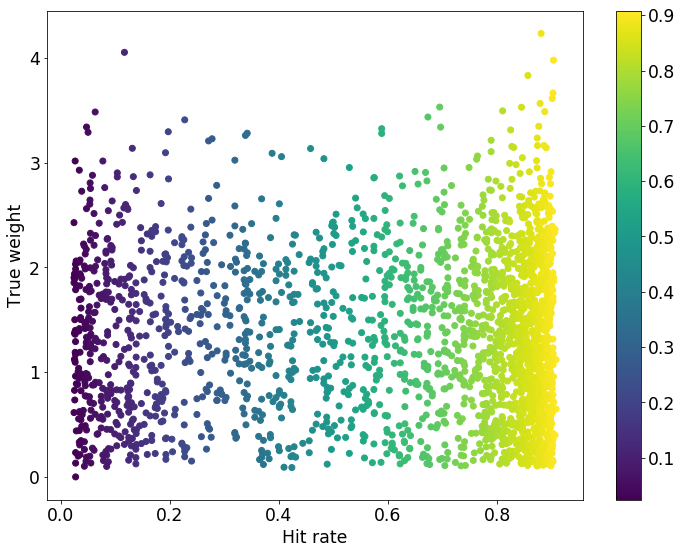

In [29]:
model = scatterplot(
    'hit_rate', 'weight', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)


plt.xlabel('Hit rate')
plt.ylabel('True weight')

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

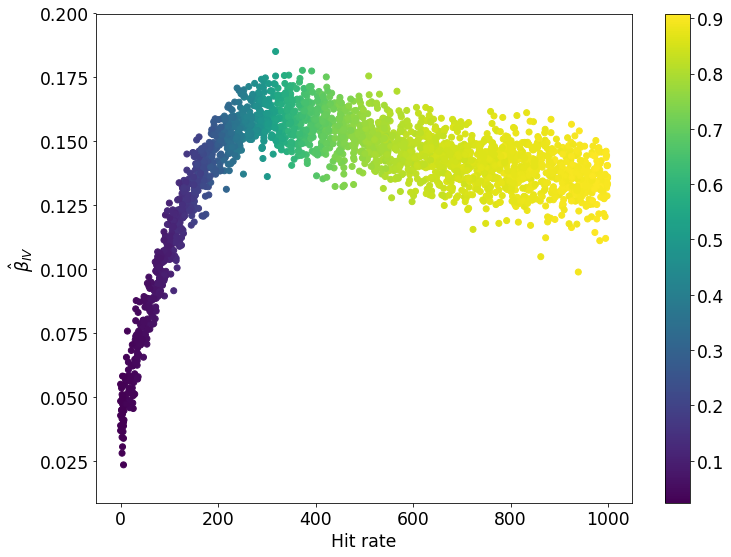

In [30]:
scatterplot(
    'source', 'beta_iv', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}_{IV}$')
# plt.xlim(.3, 0.8)

Text(0,0.5,'$\\hat{\\beta}$')

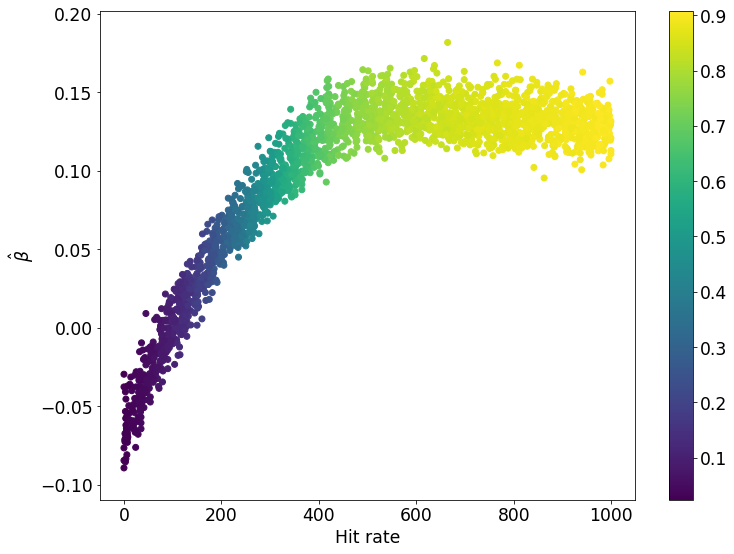

In [31]:
scatterplot(
    'source', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'source')

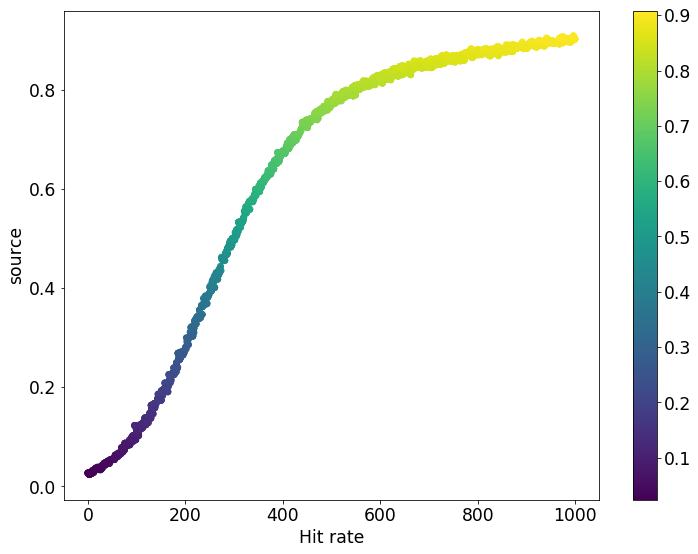

In [32]:
model = scatterplot(
    'source', 'hit_rate', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'source')

# False negatives

In [36]:
# query = 'source > 300 and source < 800 and weight > 0 and target > 1000 and target < 3200'
# query = 'source < 1000 and weight > 0 and target >= 1000 and target < 3200'
query = 'source < 1000 and target >= 1000 and target < 3200'
sample_zero = df.query(query)

In [37]:
sample_zero = sample_zero.query('weight == 0')

In [38]:
sample_zero = sample_zero.sample(2000)

In [39]:
result_zero = sample_zero.join(sample_zero.progress_apply(process, axis=1, result_type="expand"))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

In [40]:
import seaborn as sns

In [ ]:
plt.violinplot

([<matplotlib.axis.XTick at 0x7f7a866676d8>,
 <a list of 2 Text xticklabel objects>)

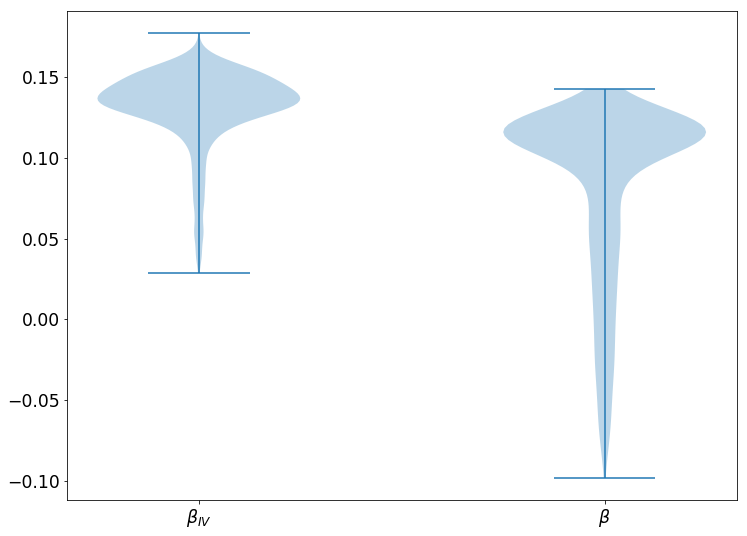

In [49]:
plt.violinplot(result_zero.loc[:, ['beta_iv', 'beta']].T)
plt.xticks([1, 2], [r'$\beta_{IV}$', r'$\beta$'])